In [70]:
!pip install tensorflow opencv-python mediapipe sklearn matplotlib

In [71]:
import cv2
import numpy as np
import os
import time
import mediapipe as mp
from matplotlib import pyplot as plt

In [72]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [73]:
def mediapipe_detection(image, model):
    image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image= cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

In [74]:
def draw_landmarks(image,results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,
                             mp_drawing.DrawingSpec(color=(80,110,10),thickness=1, circle_radius=1),
                             mp_drawing.DrawingSpec(color=(80,256,121),thickness=1, circle_radius=1)
                             )
    
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(80,22,10),thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(80,44,121),thickness=2, circle_radius=2)
                             )
    
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(121,22,76),thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(121,44,250),thickness=2, circle_radius=2))
    
    mp_drawing.draw_landmarks(image,  results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(245,112,66),thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(245,66,230),thickness=2, circle_radius=2))

In [75]:
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
        image, results = mediapipe_detection(frame, holistic)
        draw_landmarks(image, results)
        cv2.imshow('OpenCV Feed', image)
        if cv2.waitKey(10)& 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [76]:
len(results.face_landmarks.landmark)

468

In [77]:
draw_landmarks(frame, results)

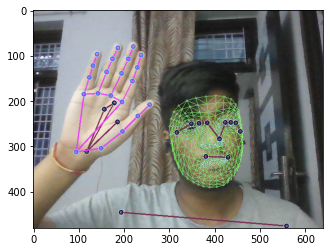

In [78]:
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))

In [79]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility]for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
    lh=np.array([[res.x, res.y, res.z]for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh=np.array([[res.x, res.y, res.z]for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    face=np.array([[res.x, res.y, res.z]for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
    return np.concatenate([pose,face,lh,rh])


In [80]:
result_test= extract_keypoints(results)

In [81]:
np.save('0', result_test)

In [82]:
np.load('0.npy')

array([ 0.64293581,  0.59163916, -1.60024834, ...,  0.22094309,
        0.20355834, -0.03096934])

In [83]:
DATA_PATH = os.path.join('MP_DATA')
actions = np.array(['hello', 'thanks', 'iloveyou'])
no_seq = 30
seq_len = 30

In [84]:
for action in actions:
    for sequence in range(no_seq):
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))       
        except:
            pass
        

In [85]:
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    for action in actions:
        for sequence in range(no_seq):
            for frame_num in range(seq_len):

                ret, frame = cap.read()
                image, results = mediapipe_detection(frame, holistic)
                draw_landmarks(image, results)
                if frame_num ==0:
                    cv2.putText(image, 'STARTING COLLECTION',(120,200),
                          cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 4, cv2.LINE_AA)
                    
                    cv2.putText(image, 'COLLECTING FRAMES for {}video Number{}'.format(action,sequence),(15,12),
                             cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1, cv2.LINE_AA)
                    cv2.waitKey(2000)
                else:
                       cv2.putText(image, 'COLLECTING FRAMES for {}video Number{}'.format(action,sequence),(15,12),
                             cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1, cv2.LINE_AA)
                
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH,action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)
                
                cv2.imshow('OpenCV Feed', image)
                if cv2.waitKey(10)& 0xFF == ord('q'):
                         break
    cap.release()
    cv2.destroyAllWindows()

In [86]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [87]:
label_map = {label:num for num , label in enumerate(actions)}

In [88]:
label_map

{'hello': 0, 'thanks': 1, 'iloveyou': 2}

In [89]:
sequences , labels = [],[]
for action in actions:
    for sequence in range(no_seq):
        window =[]
        for frame_num in range(seq_len):
            res = np.load(os. path.join(DATA_PATH,action, str(sequence),"{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [90]:
np.array(sequences).shape

(90, 30, 1662)

In [91]:
x= np.array(sequences)

In [92]:
y= to_categorical(labels).astype(int)

In [138]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.05)

In [139]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [140]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [141]:
model= Sequential()
model.add(LSTM(64,return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128,return_sequences=True, activation='relu'))
model.add(LSTM(64,return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [142]:
res= [.7,0.2,0.1]

In [143]:
actions[np.argmax(res)]

'hello'

In [144]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [145]:
model.fit(x_train,y_train, epochs=2000, callbacks=[tb_callback])

Epoch 1/2000
3/3 [==============================] - 4s 100ms/step - loss: 3.6249 - categorical_accuracy: 0.2588
Epoch 2/2000
3/3 [==============================] - 0s 92ms/step - loss: 4.6517 - categorical_accuracy: 0.4235
Epoch 3/2000
3/3 [==============================] - 0s 92ms/step - loss: 30.7599 - categorical_accuracy: 0.2000
Epoch 4/2000
3/3 [==============================] - 0s 97ms/step - loss: 83.1993 - categorical_accuracy: 0.4235
Epoch 5/2000
3/3 [==============================] - 0s 91ms/step - loss: 23.5721 - categorical_accuracy: 0.2824
Epoch 6/2000
3/3 [==============================] - 0s 93ms/step - loss: 29.4387 - categorical_accuracy: 0.2588
Epoch 7/2000
3/3 [==============================] - 0s 96ms/step - loss: 13.6052 - categorical_accuracy: 0.2941
Epoch 8/2000
3/3 [==============================] - 0s 103ms/step - loss: 10.2631 - categorical_accuracy: 0.2588
Epoch 9/2000
3/3 [==============================] - 0s 99ms/step - loss: 9.0635 - categorical_accuracy: 

3/3 [==============================] - 0s 100ms/step - loss: 0.3965 - categorical_accuracy: 0.8471
Epoch 75/2000
3/3 [==============================] - 0s 91ms/step - loss: 0.3359 - categorical_accuracy: 0.9059
Epoch 76/2000
3/3 [==============================] - 0s 92ms/step - loss: 0.3801 - categorical_accuracy: 0.9059
Epoch 77/2000
3/3 [==============================] - 0s 96ms/step - loss: 0.3348 - categorical_accuracy: 0.8941
Epoch 78/2000
3/3 [==============================] - 0s 90ms/step - loss: 0.2851 - categorical_accuracy: 0.9059
Epoch 79/2000
3/3 [==============================] - 0s 94ms/step - loss: 0.2755 - categorical_accuracy: 0.9059
Epoch 80/2000
3/3 [==============================] - 0s 94ms/step - loss: 0.2896 - categorical_accuracy: 0.8941
Epoch 81/2000
3/3 [==============================] - 0s 98ms/step - loss: 0.2549 - categorical_accuracy: 0.9294
Epoch 82/2000
3/3 [==============================] - 0s 90ms/step - loss: 0.4433 - categorical_accuracy: 0.8118
Epoch

3/3 [==============================] - 0s 95ms/step - loss: 0.2584 - categorical_accuracy: 0.8941
Epoch 147/2000
3/3 [==============================] - 0s 114ms/step - loss: 0.2449 - categorical_accuracy: 0.8941
Epoch 148/2000
3/3 [==============================] - 0s 94ms/step - loss: 0.1920 - categorical_accuracy: 0.9647
Epoch 149/2000
3/3 [==============================] - 0s 95ms/step - loss: 0.1892 - categorical_accuracy: 0.9294
Epoch 150/2000
3/3 [==============================] - 0s 88ms/step - loss: 0.1632 - categorical_accuracy: 0.9412
Epoch 151/2000
3/3 [==============================] - 0s 97ms/step - loss: 0.1551 - categorical_accuracy: 0.9529
Epoch 152/2000
3/3 [==============================] - 0s 101ms/step - loss: 0.1343 - categorical_accuracy: 0.9529
Epoch 153/2000
3/3 [==============================] - 0s 92ms/step - loss: 0.1447 - categorical_accuracy: 0.9529
Epoch 154/2000
3/3 [==============================] - 0s 92ms/step - loss: 0.1517 - categorical_accuracy: 0.9

3/3 [==============================] - 0s 96ms/step - loss: 0.9431 - categorical_accuracy: 0.6000
Epoch 219/2000
3/3 [==============================] - 0s 95ms/step - loss: 0.9201 - categorical_accuracy: 0.5882
Epoch 220/2000
3/3 [==============================] - 0s 92ms/step - loss: 0.9087 - categorical_accuracy: 0.5882
Epoch 221/2000
3/3 [==============================] - 0s 95ms/step - loss: 0.9124 - categorical_accuracy: 0.5882
Epoch 222/2000
3/3 [==============================] - 0s 94ms/step - loss: 0.8924 - categorical_accuracy: 0.6000
Epoch 223/2000
3/3 [==============================] - 0s 101ms/step - loss: 0.8975 - categorical_accuracy: 0.5765
Epoch 224/2000
3/3 [==============================] - 0s 92ms/step - loss: 0.8924 - categorical_accuracy: 0.6000
Epoch 225/2000
3/3 [==============================] - 0s 98ms/step - loss: 0.8864 - categorical_accuracy: 0.6000
Epoch 226/2000
3/3 [==============================] - 0s 99ms/step - loss: 0.8902 - categorical_accuracy: 0.61

3/3 [==============================] - 0s 101ms/step - loss: 0.8055 - categorical_accuracy: 0.6000
Epoch 291/2000
3/3 [==============================] - 0s 97ms/step - loss: 0.8101 - categorical_accuracy: 0.6000
Epoch 292/2000
3/3 [==============================] - 0s 103ms/step - loss: 0.8000 - categorical_accuracy: 0.6000
Epoch 293/2000
3/3 [==============================] - 0s 97ms/step - loss: 0.8024 - categorical_accuracy: 0.6235
Epoch 294/2000
3/3 [==============================] - 0s 99ms/step - loss: 0.8021 - categorical_accuracy: 0.6353
Epoch 295/2000
3/3 [==============================] - 0s 105ms/step - loss: 0.7995 - categorical_accuracy: 0.6235
Epoch 296/2000
3/3 [==============================] - 0s 99ms/step - loss: 0.7945 - categorical_accuracy: 0.5882
Epoch 297/2000
3/3 [==============================] - 0s 103ms/step - loss: 0.7988 - categorical_accuracy: 0.5882
Epoch 298/2000
3/3 [==============================] - 0s 93ms/step - loss: 0.8005 - categorical_accuracy: 0

3/3 [==============================] - 0s 99ms/step - loss: 0.7395 - categorical_accuracy: 0.6118
Epoch 363/2000
3/3 [==============================] - 0s 96ms/step - loss: 0.7387 - categorical_accuracy: 0.6118
Epoch 364/2000
3/3 [==============================] - 0s 95ms/step - loss: 0.7348 - categorical_accuracy: 0.6353
Epoch 365/2000
3/3 [==============================] - 0s 99ms/step - loss: 0.7453 - categorical_accuracy: 0.6235
Epoch 366/2000
3/3 [==============================] - 0s 96ms/step - loss: 0.7353 - categorical_accuracy: 0.6353
Epoch 367/2000
3/3 [==============================] - 0s 116ms/step - loss: 0.7385 - categorical_accuracy: 0.6000
Epoch 368/2000
3/3 [==============================] - 0s 98ms/step - loss: 0.7318 - categorical_accuracy: 0.6235
Epoch 369/2000
3/3 [==============================] - 0s 94ms/step - loss: 0.7397 - categorical_accuracy: 0.6000
Epoch 370/2000
3/3 [==============================] - 0s 105ms/step - loss: 0.7299 - categorical_accuracy: 0.6

3/3 [==============================] - 0s 107ms/step - loss: 0.5582 - categorical_accuracy: 0.7176
Epoch 435/2000
3/3 [==============================] - 0s 119ms/step - loss: 0.5375 - categorical_accuracy: 0.7412
Epoch 436/2000
3/3 [==============================] - 0s 105ms/step - loss: 0.5371 - categorical_accuracy: 0.7294
Epoch 437/2000
3/3 [==============================] - 0s 100ms/step - loss: 0.5254 - categorical_accuracy: 0.7765
Epoch 438/2000
3/3 [==============================] - 0s 104ms/step - loss: 0.5169 - categorical_accuracy: 0.7412
Epoch 439/2000
3/3 [==============================] - 0s 110ms/step - loss: 0.5131 - categorical_accuracy: 0.7059
Epoch 440/2000
3/3 [==============================] - 0s 99ms/step - loss: 0.4984 - categorical_accuracy: 0.7882
Epoch 441/2000
3/3 [==============================] - 0s 103ms/step - loss: 0.5101 - categorical_accuracy: 0.7059
Epoch 442/2000
3/3 [==============================] - 0s 100ms/step - loss: 0.5105 - categorical_accurac

3/3 [==============================] - 0s 108ms/step - loss: 0.5851 - categorical_accuracy: 0.7647
Epoch 507/2000
3/3 [==============================] - 0s 106ms/step - loss: 0.5098 - categorical_accuracy: 0.6588
Epoch 508/2000
3/3 [==============================] - 0s 107ms/step - loss: 0.5435 - categorical_accuracy: 0.7176
Epoch 509/2000
3/3 [==============================] - 0s 108ms/step - loss: 0.5028 - categorical_accuracy: 0.7412
Epoch 510/2000
3/3 [==============================] - 0s 104ms/step - loss: 0.5069 - categorical_accuracy: 0.7529
Epoch 511/2000
3/3 [==============================] - 0s 112ms/step - loss: 0.5306 - categorical_accuracy: 0.7176
Epoch 512/2000
3/3 [==============================] - 0s 98ms/step - loss: 0.4765 - categorical_accuracy: 0.7765
Epoch 513/2000
3/3 [==============================] - 0s 115ms/step - loss: 0.4886 - categorical_accuracy: 0.7176
Epoch 514/2000
3/3 [==============================] - 0s 100ms/step - loss: 0.4701 - categorical_accurac

3/3 [==============================] - 0s 99ms/step - loss: 0.3576 - categorical_accuracy: 0.8118
Epoch 579/2000
3/3 [==============================] - 0s 104ms/step - loss: 0.3433 - categorical_accuracy: 0.8353
Epoch 580/2000
3/3 [==============================] - 0s 96ms/step - loss: 0.3465 - categorical_accuracy: 0.8588
Epoch 581/2000
3/3 [==============================] - 0s 97ms/step - loss: 0.3509 - categorical_accuracy: 0.8235
Epoch 582/2000
3/3 [==============================] - 0s 97ms/step - loss: 0.3796 - categorical_accuracy: 0.8235
Epoch 583/2000
3/3 [==============================] - 0s 102ms/step - loss: 0.3524 - categorical_accuracy: 0.8118
Epoch 584/2000
3/3 [==============================] - 0s 101ms/step - loss: 0.3818 - categorical_accuracy: 0.7882
Epoch 585/2000
3/3 [==============================] - 0s 99ms/step - loss: 0.4247 - categorical_accuracy: 0.7412
Epoch 586/2000
3/3 [==============================] - 0s 100ms/step - loss: 0.4634 - categorical_accuracy: 0

3/3 [==============================] - 0s 101ms/step - loss: 0.4641 - categorical_accuracy: 0.8000
Epoch 651/2000
3/3 [==============================] - 0s 102ms/step - loss: 0.4476 - categorical_accuracy: 0.8118
Epoch 652/2000
3/3 [==============================] - 0s 102ms/step - loss: 0.4838 - categorical_accuracy: 0.7647
Epoch 653/2000
3/3 [==============================] - 0s 102ms/step - loss: 0.4659 - categorical_accuracy: 0.8235
Epoch 654/2000
3/3 [==============================] - 0s 99ms/step - loss: 0.5091 - categorical_accuracy: 0.7765
Epoch 655/2000
3/3 [==============================] - 0s 101ms/step - loss: 0.4382 - categorical_accuracy: 0.8235
Epoch 656/2000
3/3 [==============================] - 0s 96ms/step - loss: 0.4501 - categorical_accuracy: 0.8471
Epoch 657/2000
3/3 [==============================] - 0s 99ms/step - loss: 0.4433 - categorical_accuracy: 0.8353
Epoch 658/2000
3/3 [==============================] - 0s 106ms/step - loss: 0.4083 - categorical_accuracy:

3/3 [==============================] - 0s 108ms/step - loss: 0.4022 - categorical_accuracy: 0.8118
Epoch 723/2000
3/3 [==============================] - 0s 106ms/step - loss: 0.4470 - categorical_accuracy: 0.8471
Epoch 724/2000
3/3 [==============================] - 0s 99ms/step - loss: 0.4025 - categorical_accuracy: 0.8235
Epoch 725/2000
3/3 [==============================] - 0s 108ms/step - loss: 0.3207 - categorical_accuracy: 0.8588
Epoch 726/2000
3/3 [==============================] - 0s 100ms/step - loss: 0.3452 - categorical_accuracy: 0.8588
Epoch 727/2000
3/3 [==============================] - 0s 100ms/step - loss: 0.2944 - categorical_accuracy: 0.9176
Epoch 728/2000
3/3 [==============================] - 0s 100ms/step - loss: 0.3162 - categorical_accuracy: 0.8824
Epoch 729/2000
3/3 [==============================] - 0s 102ms/step - loss: 0.3316 - categorical_accuracy: 0.8706
Epoch 730/2000
3/3 [==============================] - 0s 112ms/step - loss: 0.2877 - categorical_accurac

3/3 [==============================] - 0s 99ms/step - loss: 0.2120 - categorical_accuracy: 0.9176
Epoch 795/2000
3/3 [==============================] - 0s 104ms/step - loss: 0.2129 - categorical_accuracy: 0.9294
Epoch 796/2000
3/3 [==============================] - 0s 105ms/step - loss: 0.2047 - categorical_accuracy: 0.9176
Epoch 797/2000
3/3 [==============================] - 0s 104ms/step - loss: 0.1986 - categorical_accuracy: 0.9176
Epoch 798/2000
3/3 [==============================] - 0s 104ms/step - loss: 0.1962 - categorical_accuracy: 0.9176
Epoch 799/2000
3/3 [==============================] - 0s 98ms/step - loss: 0.1896 - categorical_accuracy: 0.9294
Epoch 800/2000
3/3 [==============================] - 0s 101ms/step - loss: 0.1823 - categorical_accuracy: 0.9176
Epoch 801/2000
3/3 [==============================] - 0s 94ms/step - loss: 0.1770 - categorical_accuracy: 0.9294
Epoch 802/2000
3/3 [==============================] - 0s 105ms/step - loss: 0.1773 - categorical_accuracy:

3/3 [==============================] - 0s 102ms/step - loss: 0.6919 - categorical_accuracy: 0.7529
Epoch 867/2000
3/3 [==============================] - 0s 101ms/step - loss: 0.7732 - categorical_accuracy: 0.6353
Epoch 868/2000
3/3 [==============================] - 0s 103ms/step - loss: 0.6466 - categorical_accuracy: 0.6941
Epoch 869/2000
3/3 [==============================] - 0s 106ms/step - loss: 0.4730 - categorical_accuracy: 0.8588
Epoch 870/2000
3/3 [==============================] - 0s 102ms/step - loss: 0.4586 - categorical_accuracy: 0.7882
Epoch 871/2000
3/3 [==============================] - 0s 101ms/step - loss: 0.4113 - categorical_accuracy: 0.8824
Epoch 872/2000
3/3 [==============================] - 0s 98ms/step - loss: 0.4000 - categorical_accuracy: 0.8235
Epoch 873/2000
3/3 [==============================] - 0s 101ms/step - loss: 0.3709 - categorical_accuracy: 0.8353
Epoch 874/2000
3/3 [==============================] - 0s 103ms/step - loss: 0.3214 - categorical_accurac

3/3 [==============================] - 0s 107ms/step - loss: 0.0973 - categorical_accuracy: 0.9765
Epoch 939/2000
3/3 [==============================] - 0s 101ms/step - loss: 0.0960 - categorical_accuracy: 0.9765
Epoch 940/2000
3/3 [==============================] - 0s 103ms/step - loss: 0.0947 - categorical_accuracy: 0.9765
Epoch 941/2000
3/3 [==============================] - 0s 101ms/step - loss: 0.0943 - categorical_accuracy: 0.9765
Epoch 942/2000
3/3 [==============================] - 0s 102ms/step - loss: 0.0926 - categorical_accuracy: 0.9765
Epoch 943/2000
3/3 [==============================] - 0s 108ms/step - loss: 0.0920 - categorical_accuracy: 0.9765
Epoch 944/2000
3/3 [==============================] - 0s 105ms/step - loss: 0.0914 - categorical_accuracy: 0.9765
Epoch 945/2000
3/3 [==============================] - 0s 100ms/step - loss: 0.0910 - categorical_accuracy: 0.9765
Epoch 946/2000
3/3 [==============================] - 0s 103ms/step - loss: 0.0903 - categorical_accura

3/3 [==============================] - 0s 99ms/step - loss: 0.1977 - categorical_accuracy: 0.9529
Epoch 1011/2000
3/3 [==============================] - 0s 101ms/step - loss: 0.1926 - categorical_accuracy: 0.9529
Epoch 1012/2000
3/3 [==============================] - 0s 102ms/step - loss: 0.1840 - categorical_accuracy: 0.9529
Epoch 1013/2000
3/3 [==============================] - 0s 103ms/step - loss: 0.1793 - categorical_accuracy: 0.9412
Epoch 1014/2000
3/3 [==============================] - 0s 102ms/step - loss: 0.1769 - categorical_accuracy: 0.9412
Epoch 1015/2000
3/3 [==============================] - 0s 102ms/step - loss: 0.1712 - categorical_accuracy: 0.9412
Epoch 1016/2000
3/3 [==============================] - 0s 101ms/step - loss: 0.1665 - categorical_accuracy: 0.9412
Epoch 1017/2000
3/3 [==============================] - 0s 95ms/step - loss: 0.1630 - categorical_accuracy: 0.9647
Epoch 1018/2000
3/3 [==============================] - 0s 98ms/step - loss: 0.1468 - categorical_a

3/3 [==============================] - 0s 105ms/step - loss: 0.0543 - categorical_accuracy: 0.9765
Epoch 1082/2000
3/3 [==============================] - 0s 111ms/step - loss: 0.0532 - categorical_accuracy: 0.9765
Epoch 1083/2000
3/3 [==============================] - 0s 101ms/step - loss: 0.0528 - categorical_accuracy: 0.9765
Epoch 1084/2000
3/3 [==============================] - 0s 108ms/step - loss: 0.0518 - categorical_accuracy: 0.9765
Epoch 1085/2000
3/3 [==============================] - 0s 98ms/step - loss: 0.0505 - categorical_accuracy: 0.9765
Epoch 1086/2000
3/3 [==============================] - 0s 104ms/step - loss: 0.0492 - categorical_accuracy: 0.9765
Epoch 1087/2000
3/3 [==============================] - 0s 105ms/step - loss: 0.0487 - categorical_accuracy: 0.9765
Epoch 1088/2000
3/3 [==============================] - 0s 102ms/step - loss: 0.0475 - categorical_accuracy: 0.9765
Epoch 1089/2000
3/3 [==============================] - 0s 97ms/step - loss: 0.0461 - categorical_

3/3 [==============================] - 0s 105ms/step - loss: 0.0629 - categorical_accuracy: 0.9765
Epoch 1153/2000
3/3 [==============================] - 0s 101ms/step - loss: 0.0621 - categorical_accuracy: 0.9765
Epoch 1154/2000
3/3 [==============================] - 0s 108ms/step - loss: 0.0621 - categorical_accuracy: 0.9765
Epoch 1155/2000
3/3 [==============================] - 0s 105ms/step - loss: 0.0611 - categorical_accuracy: 0.9765
Epoch 1156/2000
3/3 [==============================] - 0s 104ms/step - loss: 0.0611 - categorical_accuracy: 0.9765
Epoch 1157/2000
3/3 [==============================] - 0s 107ms/step - loss: 0.0583 - categorical_accuracy: 0.9765
Epoch 1158/2000
3/3 [==============================] - 0s 101ms/step - loss: 0.0626 - categorical_accuracy: 0.9765
Epoch 1159/2000
3/3 [==============================] - 0s 100ms/step - loss: 0.0614 - categorical_accuracy: 0.9765
Epoch 1160/2000
3/3 [==============================] - 0s 98ms/step - loss: 0.0607 - categorical

3/3 [==============================] - 0s 105ms/step - loss: 0.2152 - categorical_accuracy: 0.9294
Epoch 1224/2000
3/3 [==============================] - 0s 98ms/step - loss: 0.3055 - categorical_accuracy: 0.9059
Epoch 1225/2000
3/3 [==============================] - 0s 99ms/step - loss: 0.7639 - categorical_accuracy: 0.8000
Epoch 1226/2000
3/3 [==============================] - 0s 97ms/step - loss: 0.3707 - categorical_accuracy: 0.8588
Epoch 1227/2000
3/3 [==============================] - 0s 99ms/step - loss: 0.2023 - categorical_accuracy: 0.9412
Epoch 1228/2000
3/3 [==============================] - 0s 107ms/step - loss: 0.2608 - categorical_accuracy: 0.9059
Epoch 1229/2000
3/3 [==============================] - 0s 103ms/step - loss: 0.2439 - categorical_accuracy: 0.9412
Epoch 1230/2000
3/3 [==============================] - 0s 104ms/step - loss: 0.2280 - categorical_accuracy: 0.9412
Epoch 1231/2000
3/3 [==============================] - 0s 110ms/step - loss: 0.2024 - categorical_ac

3/3 [==============================] - 0s 109ms/step - loss: 0.1015 - categorical_accuracy: 0.9647
Epoch 1295/2000
3/3 [==============================] - 0s 103ms/step - loss: 1.5616 - categorical_accuracy: 0.7529
Epoch 1296/2000
3/3 [==============================] - 0s 103ms/step - loss: 1.2816 - categorical_accuracy: 0.6706
Epoch 1297/2000
3/3 [==============================] - 0s 103ms/step - loss: 1.5208 - categorical_accuracy: 0.5059
Epoch 1298/2000
3/3 [==============================] - 0s 98ms/step - loss: 1.5774 - categorical_accuracy: 0.4824
Epoch 1299/2000
3/3 [==============================] - 0s 98ms/step - loss: 1.2920 - categorical_accuracy: 0.5765
Epoch 1300/2000
3/3 [==============================] - 0s 96ms/step - loss: 0.8248 - categorical_accuracy: 0.6471
Epoch 1301/2000
3/3 [==============================] - 0s 102ms/step - loss: 0.7831 - categorical_accuracy: 0.5059
Epoch 1302/2000
3/3 [==============================] - 0s 103ms/step - loss: 0.9483 - categorical_a

3/3 [==============================] - 0s 106ms/step - loss: 0.1634 - categorical_accuracy: 0.9412
Epoch 1366/2000
3/3 [==============================] - 0s 106ms/step - loss: 0.1600 - categorical_accuracy: 0.9412
Epoch 1367/2000
3/3 [==============================] - 0s 110ms/step - loss: 0.1582 - categorical_accuracy: 0.9412
Epoch 1368/2000
3/3 [==============================] - 0s 108ms/step - loss: 0.1526 - categorical_accuracy: 0.9412
Epoch 1369/2000
3/3 [==============================] - 0s 98ms/step - loss: 0.1589 - categorical_accuracy: 0.9294
Epoch 1370/2000
3/3 [==============================] - 0s 106ms/step - loss: 0.1496 - categorical_accuracy: 0.9412
Epoch 1371/2000
3/3 [==============================] - 0s 99ms/step - loss: 0.1510 - categorical_accuracy: 0.9412
Epoch 1372/2000
3/3 [==============================] - 0s 102ms/step - loss: 0.1439 - categorical_accuracy: 0.9412
Epoch 1373/2000
3/3 [==============================] - 0s 96ms/step - loss: 0.1447 - categorical_a

3/3 [==============================] - 0s 103ms/step - loss: 0.0922 - categorical_accuracy: 0.9647
Epoch 1437/2000
3/3 [==============================] - 0s 101ms/step - loss: 0.0902 - categorical_accuracy: 0.9647
Epoch 1438/2000
3/3 [==============================] - 0s 104ms/step - loss: 0.0927 - categorical_accuracy: 0.9647
Epoch 1439/2000
3/3 [==============================] - 0s 104ms/step - loss: 0.0908 - categorical_accuracy: 0.9529
Epoch 1440/2000
3/3 [==============================] - 0s 103ms/step - loss: 0.0891 - categorical_accuracy: 0.9647
Epoch 1441/2000
3/3 [==============================] - 0s 100ms/step - loss: 0.1417 - categorical_accuracy: 0.9412
Epoch 1442/2000
3/3 [==============================] - 0s 101ms/step - loss: 0.6604 - categorical_accuracy: 0.8824
Epoch 1443/2000
3/3 [==============================] - 0s 100ms/step - loss: 0.7012 - categorical_accuracy: 0.8235
Epoch 1444/2000
3/3 [==============================] - 0s 100ms/step - loss: 0.2956 - categorica

3/3 [==============================] - 0s 97ms/step - loss: 0.0644 - categorical_accuracy: 0.9647
Epoch 1508/2000
3/3 [==============================] - 0s 96ms/step - loss: 0.0662 - categorical_accuracy: 0.9765
Epoch 1509/2000
3/3 [==============================] - 0s 103ms/step - loss: 0.0622 - categorical_accuracy: 0.9765
Epoch 1510/2000
3/3 [==============================] - 0s 105ms/step - loss: 0.0662 - categorical_accuracy: 0.9765
Epoch 1511/2000
3/3 [==============================] - 0s 106ms/step - loss: 0.0622 - categorical_accuracy: 0.9765
Epoch 1512/2000
3/3 [==============================] - 0s 98ms/step - loss: 0.0619 - categorical_accuracy: 0.9765
Epoch 1513/2000
3/3 [==============================] - 0s 100ms/step - loss: 0.0610 - categorical_accuracy: 0.9647
Epoch 1514/2000
3/3 [==============================] - 0s 103ms/step - loss: 0.0600 - categorical_accuracy: 0.9647
Epoch 1515/2000
3/3 [==============================] - 0s 101ms/step - loss: 0.0589 - categorical_a

3/3 [==============================] - 0s 106ms/step - loss: 0.4192 - categorical_accuracy: 0.9412
Epoch 1579/2000
3/3 [==============================] - 0s 106ms/step - loss: 0.4157 - categorical_accuracy: 0.9412
Epoch 1580/2000
3/3 [==============================] - 0s 101ms/step - loss: 0.4105 - categorical_accuracy: 0.9412
Epoch 1581/2000
3/3 [==============================] - 0s 106ms/step - loss: 0.4038 - categorical_accuracy: 0.9412
Epoch 1582/2000
3/3 [==============================] - 0s 107ms/step - loss: 0.3978 - categorical_accuracy: 0.9412
Epoch 1583/2000
3/3 [==============================] - 0s 107ms/step - loss: 0.3911 - categorical_accuracy: 0.9412
Epoch 1584/2000
3/3 [==============================] - 0s 106ms/step - loss: 0.3795 - categorical_accuracy: 0.9294
Epoch 1585/2000
3/3 [==============================] - 0s 108ms/step - loss: 0.3745 - categorical_accuracy: 0.9294
Epoch 1586/2000
3/3 [==============================] - 0s 101ms/step - loss: 0.3594 - categorica

3/3 [==============================] - 0s 99ms/step - loss: 0.1529 - categorical_accuracy: 0.9529
Epoch 1650/2000
3/3 [==============================] - 0s 102ms/step - loss: 0.1496 - categorical_accuracy: 0.9529
Epoch 1651/2000
3/3 [==============================] - 0s 104ms/step - loss: 0.1419 - categorical_accuracy: 0.9529
Epoch 1652/2000
3/3 [==============================] - 0s 99ms/step - loss: 0.1451 - categorical_accuracy: 0.9529
Epoch 1653/2000
3/3 [==============================] - 0s 103ms/step - loss: 0.1356 - categorical_accuracy: 0.9529
Epoch 1654/2000
3/3 [==============================] - 0s 105ms/step - loss: 0.1325 - categorical_accuracy: 0.9529
Epoch 1655/2000
3/3 [==============================] - 0s 105ms/step - loss: 0.1302 - categorical_accuracy: 0.9529
Epoch 1656/2000
3/3 [==============================] - 0s 102ms/step - loss: 0.1248 - categorical_accuracy: 0.9529
Epoch 1657/2000
3/3 [==============================] - 0s 97ms/step - loss: 0.1247 - categorical_a

3/3 [==============================] - 0s 101ms/step - loss: 0.9220 - categorical_accuracy: 0.5765
Epoch 1721/2000
3/3 [==============================] - 0s 105ms/step - loss: 0.6726 - categorical_accuracy: 0.5765
Epoch 1722/2000
3/3 [==============================] - 0s 101ms/step - loss: 0.7365 - categorical_accuracy: 0.6353
Epoch 1723/2000
3/3 [==============================] - 0s 99ms/step - loss: 0.6824 - categorical_accuracy: 0.6706
Epoch 1724/2000
3/3 [==============================] - 0s 103ms/step - loss: 0.5985 - categorical_accuracy: 0.6588
Epoch 1725/2000
3/3 [==============================] - 0s 101ms/step - loss: 0.5792 - categorical_accuracy: 0.6588
Epoch 1726/2000
3/3 [==============================] - 0s 103ms/step - loss: 0.4864 - categorical_accuracy: 0.6588
Epoch 1727/2000
3/3 [==============================] - 0s 100ms/step - loss: 0.4549 - categorical_accuracy: 0.6588
Epoch 1728/2000
3/3 [==============================] - 0s 103ms/step - loss: 0.4637 - categorical

3/3 [==============================] - 0s 99ms/step - loss: 0.1102 - categorical_accuracy: 0.9882
Epoch 1792/2000
3/3 [==============================] - 0s 106ms/step - loss: 0.0943 - categorical_accuracy: 0.9765
Epoch 1793/2000
3/3 [==============================] - 0s 103ms/step - loss: 0.0860 - categorical_accuracy: 0.9882
Epoch 1794/2000
3/3 [==============================] - 0s 109ms/step - loss: 0.0889 - categorical_accuracy: 0.9882
Epoch 1795/2000
3/3 [==============================] - 0s 109ms/step - loss: 0.0771 - categorical_accuracy: 0.9882
Epoch 1796/2000
3/3 [==============================] - 0s 108ms/step - loss: 0.0778 - categorical_accuracy: 1.0000
Epoch 1797/2000
3/3 [==============================] - 0s 103ms/step - loss: 0.0896 - categorical_accuracy: 0.9647
Epoch 1798/2000
3/3 [==============================] - 0s 108ms/step - loss: 0.0812 - categorical_accuracy: 0.9882
Epoch 1799/2000
3/3 [==============================] - 0s 101ms/step - loss: 0.0844 - categorical

3/3 [==============================] - 0s 106ms/step - loss: 0.0206 - categorical_accuracy: 1.0000
Epoch 1863/2000
3/3 [==============================] - 0s 104ms/step - loss: 0.0202 - categorical_accuracy: 1.0000
Epoch 1864/2000
3/3 [==============================] - 0s 108ms/step - loss: 0.0202 - categorical_accuracy: 1.0000
Epoch 1865/2000
3/3 [==============================] - 0s 103ms/step - loss: 0.0200 - categorical_accuracy: 1.0000
Epoch 1866/2000
3/3 [==============================] - 0s 106ms/step - loss: 0.0203 - categorical_accuracy: 1.0000
Epoch 1867/2000
3/3 [==============================] - 0s 119ms/step - loss: 0.0185 - categorical_accuracy: 1.0000
Epoch 1868/2000
3/3 [==============================] - 0s 112ms/step - loss: 0.0196 - categorical_accuracy: 1.0000
Epoch 1869/2000
3/3 [==============================] - 0s 106ms/step - loss: 0.0191 - categorical_accuracy: 1.0000
Epoch 1870/2000
3/3 [==============================] - 0s 109ms/step - loss: 0.0186 - categorica

3/3 [==============================] - 0s 101ms/step - loss: 0.0084 - categorical_accuracy: 1.0000
Epoch 1934/2000
3/3 [==============================] - 0s 110ms/step - loss: 0.0082 - categorical_accuracy: 1.0000
Epoch 1935/2000
3/3 [==============================] - 0s 105ms/step - loss: 0.0082 - categorical_accuracy: 1.0000
Epoch 1936/2000
3/3 [==============================] - 0s 140ms/step - loss: 0.0080 - categorical_accuracy: 1.0000
Epoch 1937/2000
3/3 [==============================] - 0s 104ms/step - loss: 0.0081 - categorical_accuracy: 1.0000
Epoch 1938/2000
3/3 [==============================] - 0s 117ms/step - loss: 0.0084 - categorical_accuracy: 1.0000
Epoch 1939/2000
3/3 [==============================] - 0s 115ms/step - loss: 0.0081 - categorical_accuracy: 1.0000
Epoch 1940/2000
3/3 [==============================] - 0s 108ms/step - loss: 0.0077 - categorical_accuracy: 1.0000
Epoch 1941/2000
3/3 [==============================] - 0s 104ms/step - loss: 0.0076 - categorica

In [146]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 30, 64)            442112    
                                                                 
 lstm_19 (LSTM)              (None, 30, 128)           98816     
                                                                 
 lstm_20 (LSTM)              (None, 64)                49408     
                                                                 
 dense_18 (Dense)            (None, 64)                4160      
                                                                 
 dense_19 (Dense)            (None, 32)                2080      
                                                                 
 dense_20 (Dense)            (None, 3)                 99        
                                                                 
Total params: 596,675
Trainable params: 596,675
Non-tr

In [147]:
res = model.predict(x_test)

1/1 [==============================] - 1s 551ms/step


In [148]:
actions[np.argmax(res[0])]

'hello'

In [149]:
actions[np.argmax(y_test[0])]

'hello'

In [150]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [151]:
yhat = model.predict(x_train)

3/3 [==============================] - 0s 39ms/step


In [152]:
ytrue = np.argmax(y_train, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [153]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[57,  0],
        [ 0, 28]],

       [[56,  0],
        [ 0, 29]],

       [[57,  0],
        [ 0, 28]]], dtype=int64)

In [154]:
accuracy_score(ytrue, yhat)

1.0

In [174]:
colors= [(245,117,16), (117,245,16),(16,117,245)]
def prob_viz(res,actions,input_frame,colors):
    output_frame= input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0, 60+num*4),(int(prob*100),90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255), 2, cv2.LINE_AA)
    return output_frame

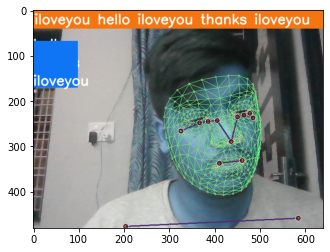

In [175]:
plt.imshow(prob_viz(res, actions, image, colors))

In [176]:
sequence = []
sentence = []
threshold = 0.4

cap = cv2.VideoCapture(0)

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
        image, results = mediapipe_detection(frame, holistic)
        draw_landmarks(image, results)
        
        keypoints = extract_keypoints(results)
        sequence.insert(0, keypoints)
        sequence = sequence[:30]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            
            if res[np.argmax(res)] > threshold:
                if len(sentence) > 0:
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5:
                sentence = sentence[-5:]
                
        image = prob_viz(res, actions, image, colors)
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30),
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        cv2.imshow('OpenCV Feed', image)
        
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()


1/1 [==============================] - 0s 22ms/step
hello
1/1 [==============================] - 0s 19ms/step
hello
1/1 [==============================] - 0s 23ms/step
hello
1/1 [==============================] - 0s 20ms/step
hello
1/1 [==============================] - 0s 18ms/step
hello
1/1 [==============================] - 0s 19ms/step
hello
1/1 [==============================] - 0s 20ms/step
hello
1/1 [==============================] - 0s 18ms/step
hello
1/1 [==============================] - 0s 18ms/step
hello
1/1 [==============================] - 0s 19ms/step
hello
1/1 [==============================] - 0s 18ms/step
hello
1/1 [==============================] - 0s 20ms/step
hello
1/1 [==============================] - 0s 21ms/step
hello
1/1 [==============================] - 0s 19ms/step
hello
1/1 [==============================] - 0s 20ms/step
hello
1/1 [==============================] - 0s 22ms/step
hello
1/1 [==============================] - 0s 19ms/step
hello
1/1 [=========

1/1 [==============================] - 0s 18ms/step
thanks
1/1 [==============================] - 0s 20ms/step
thanks
1/1 [==============================] - 0s 20ms/step
thanks
1/1 [==============================] - 0s 19ms/step
thanks
1/1 [==============================] - 0s 21ms/step
thanks
1/1 [==============================] - 0s 18ms/step
thanks
1/1 [==============================] - 0s 22ms/step
thanks
1/1 [==============================] - 0s 21ms/step
thanks
1/1 [==============================] - 0s 19ms/step
thanks
1/1 [==============================] - 0s 20ms/step
thanks
1/1 [==============================] - 0s 20ms/step
thanks
1/1 [==============================] - 0s 21ms/step
thanks
1/1 [==============================] - 0s 19ms/step
thanks
1/1 [==============================] - 0s 19ms/step
thanks
1/1 [==============================] - 0s 21ms/step
thanks
1/1 [==============================] - 0s 19ms/step
thanks
1/1 [==============================] - 0s 20ms/step
than